In [1]:
import numpy as np
import scipy

import cupy as cp
import cupyx.scipy

import astropy.units as u
from astropy.io import fits
from matplotlib.patches import Rectangle, Circle
from pathlib import Path
from IPython.display import clear_output, display, HTML
display(HTML("<style>.container { width:90% !important; }</style>")) # just making the notebook cells wider
from datetime import datetime
today = int(datetime.today().strftime('%Y%m%d'))

from importlib import reload

import time

import logging, sys
poppy_log = logging.getLogger('poppy')
poppy_log.setLevel('DEBUG')
logging.basicConfig(stream=sys.stdout, level=logging.INFO)

poppy_log.disabled = True

import warnings
warnings.filterwarnings("ignore")

import cgi_phasec_poppy
    
from math_module import xp, ensure_np_array
import iefc_2dm 
import utils
from imshows import *

data_dir = iefc_2dm.iefc_data_dir
response_dir = data_dir/'response-data'


dm1_flat = fits.getdata(cgi_phasec_poppy.data_dir/'dm-acts'/'flatmaps'/'spc_wide_band4_flattened_dm1.fits')
dm2_flat = fits.getdata(cgi_phasec_poppy.data_dir/'dm-acts'/'flatmaps'/'spc_wide_band4_flattened_dm2.fits')




INFO:numexpr.utils:Note: NumExpr detected 64 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


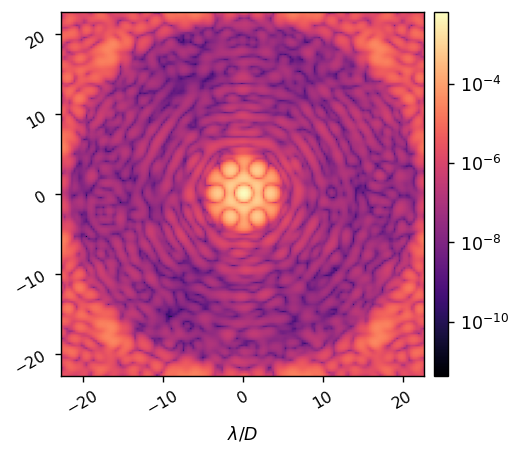

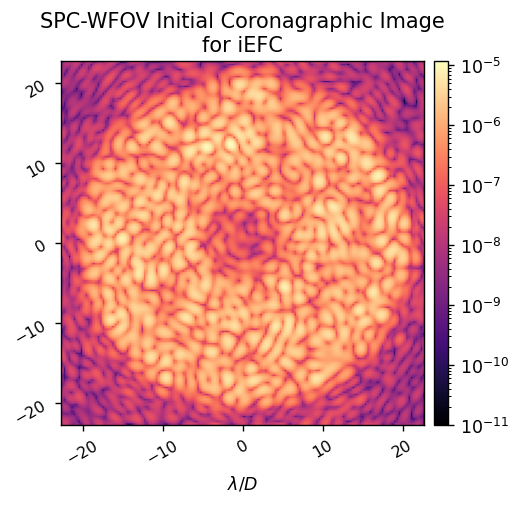

1.105575444465351e-06


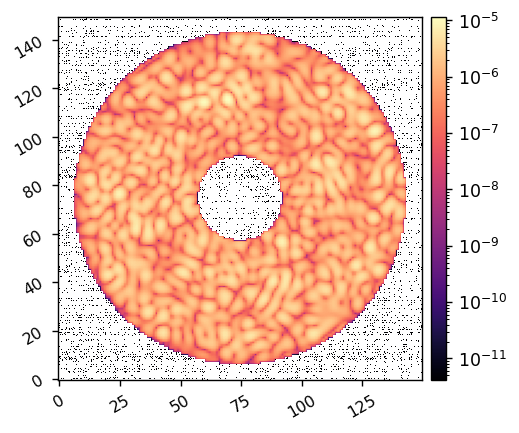

In [2]:
mode = cgi_phasec_poppy.cgi.CGI(cgi_mode='spc-wide', npsf=150,
                                  use_pupil_defocus=True, 
                                  use_opds=True, 
                                  dm1_ref=2*dm1_flat, 
                                #   dm2_ref=dm2_flat,
                                  )
mode.use_fpm = False
ref_unocc_im = mode.snap()
imshow1(ref_unocc_im, pxscl=mode.psf_pixelscale_lamD, xlabel='$\lambda/D$', lognorm=True)

mode.Imax_ref = ref_unocc_im.get().max()
mode.use_fpm = True

ref_im = mode.snap()
imshow1(ref_im, 'SPC-WFOV Initial Coronagraphic Image\nfor iEFC',
        pxscl=mode.psf_pixelscale_lamD, xlabel='$\lambda/D$', lognorm=True, vmin=1e-11)

reload(utils)
control_mask = utils.create_annular_focal_plane_mask(mode, inner_radius=5.4, outer_radius=20.6, edge=None)

mean_ni = xp.mean(ref_im[control_mask])
print(mean_ni)
imshow1(control_mask*ref_im, lognorm=True)

# Create calibration and probe modes

In [8]:
calib_modes = utils.create_hadamard_modes(mode.dm_mask, ndms=2)


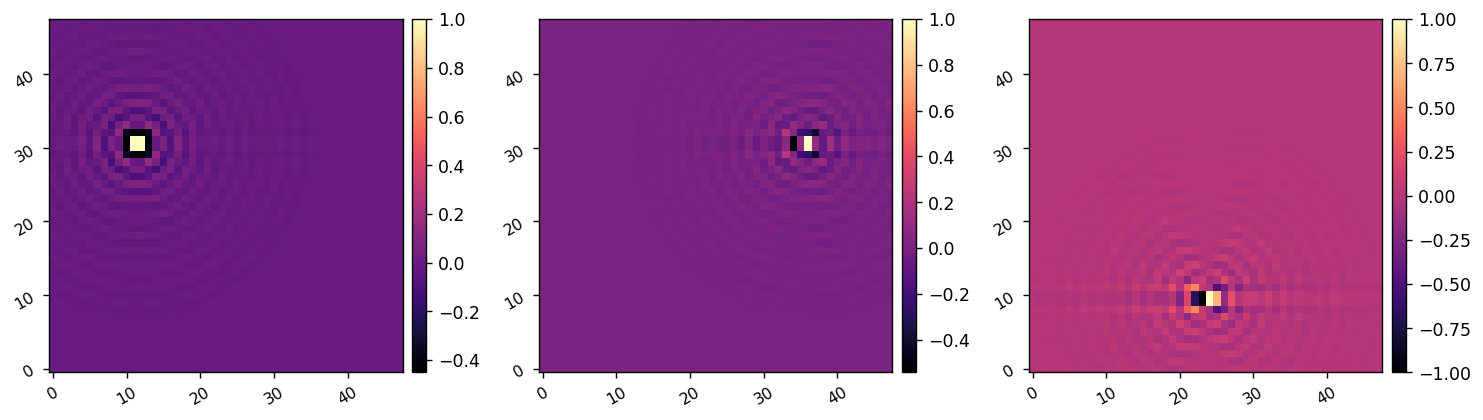

In [9]:
probe_amp = 20e-9
# probe_modes = utils.create_poke_probes([(10,34), (38,34), (24,10)], plot=True)
# probe_modes = utils.create_poke_probes([(11,31), (36,31), (23,9)], plot=True)
probe_modes = utils.create_fourier_probes(mode, control_mask, fourier_sampling=0.25,
                                          shift=[(-12,7), (12,7),(0,-14)], nprobes=3,
                                          use_weighting=True)
imshow3(probe_modes[0], probe_modes[1], probe_modes[2])

calib_modes = utils.create_hadamard_modes(mode.dm_mask, ndms=2)


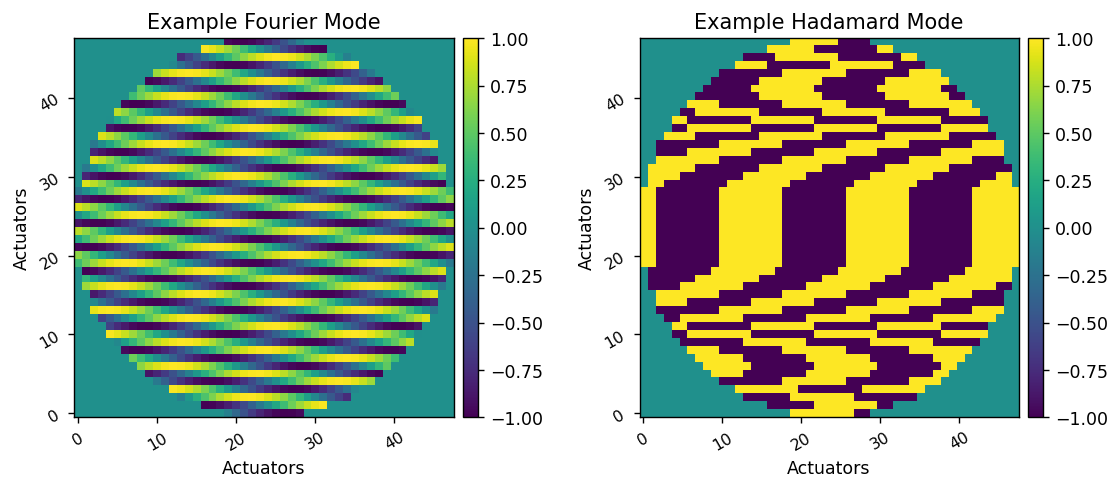

In [6]:
had_modes = utils.create_hadamard_modes(mode.dm_mask, ndms=1)
hi = 8
fourier_modes = utils.create_fourier_modes(mode, control_mask, fourier_sampling=1, ndms=1)
fi = 100

probe_1_ind = tuple(np.roll(np.argwhere(probe_modes[0])[0],1))
probe_2_ind = tuple(np.roll(np.argwhere(probe_modes[1])[0],1))
probe_3_ind = tuple(np.roll(np.argwhere(probe_modes[2])[0],1))
patches1 = [Circle(probe_1_ind, 1, color='red'), Circle(probe_2_ind, 1, color='red'), Circle(probe_3_ind, 1, color='red')]
patches2 = [Circle(probe_1_ind, 1, color='red'), Circle(probe_2_ind, 1, color='red'), Circle(probe_3_ind, 1, color='red')]

fig,ax = imshow2(fourier_modes[fi].reshape(mode.Nact,mode.Nact), had_modes[hi].reshape(mode.Nact,mode.Nact),
        'Example Fourier Mode', 'Example Hadamard Mode', 
        xlabel='Actuators',
        cmap1='viridis', cmap2='viridis', 
        # patches1=patches1, 
        # patches2=patches2,
        wspace=0.4,
        return_fig=True, display_fig=False,
        )
ax[0].set_ylabel('Actuators')
ax[1].set_ylabel('Actuators')
display(fig)

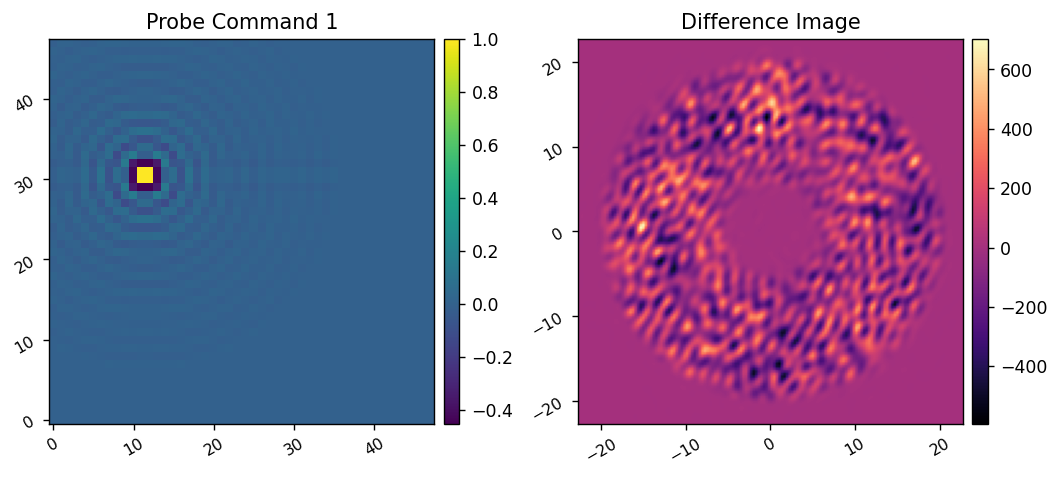

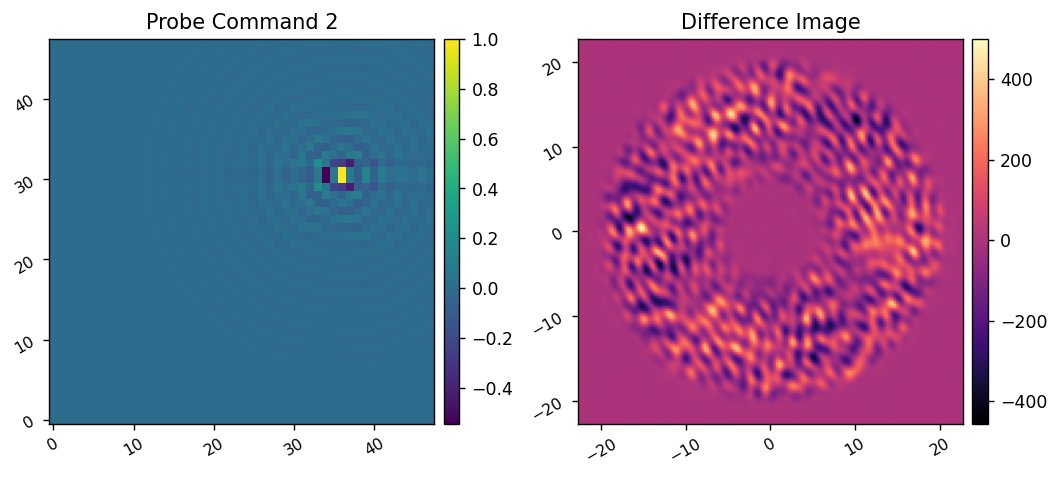

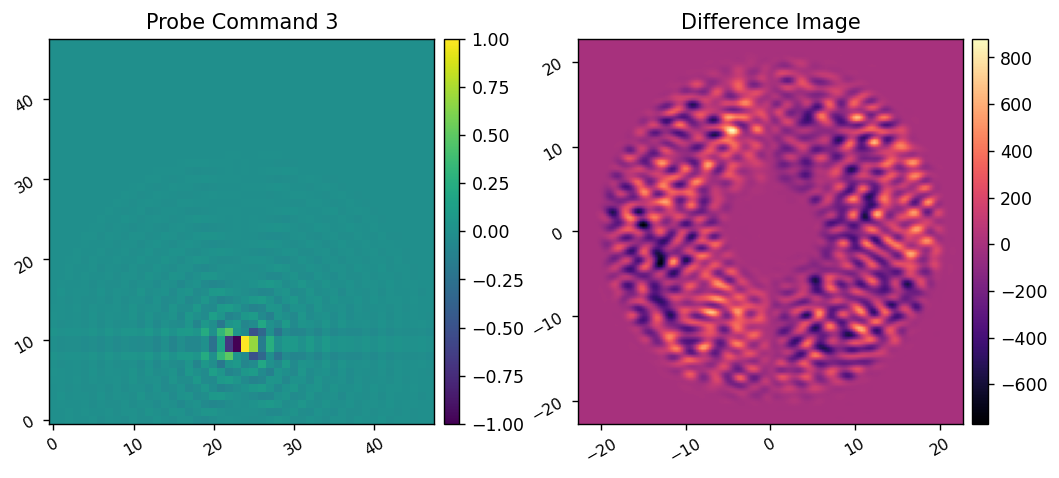

In [5]:
reload(iefc_2dm)

mode.exp_times_list = None
differential_images, single_images = iefc_2dm.take_measurement(mode, probe_modes, probe_amp, return_all=True, plot=True)
ims = differential_images.reshape(probe_modes.shape[0], mode.npsf, mode.npsf)

Calibrating iEFC...
	Calibrated mode 2/2 in 4.977s
Calibration complete.


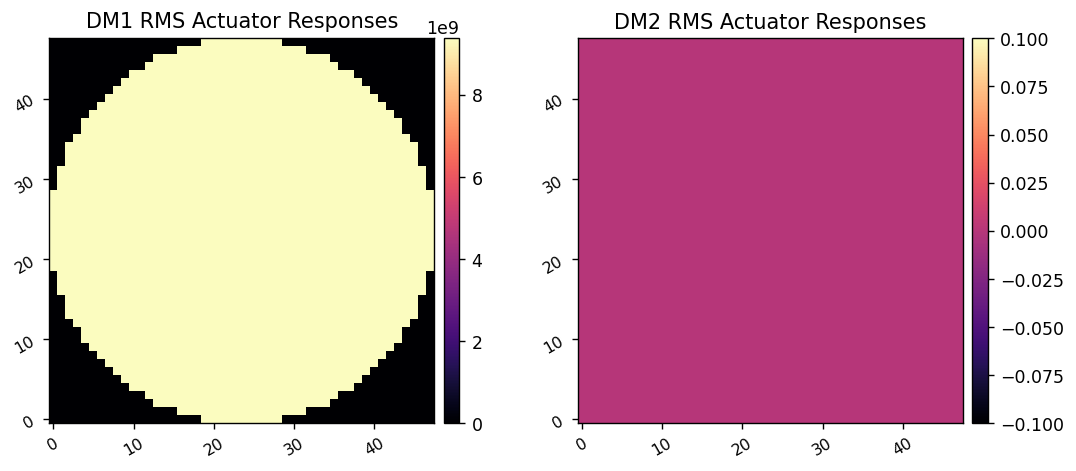

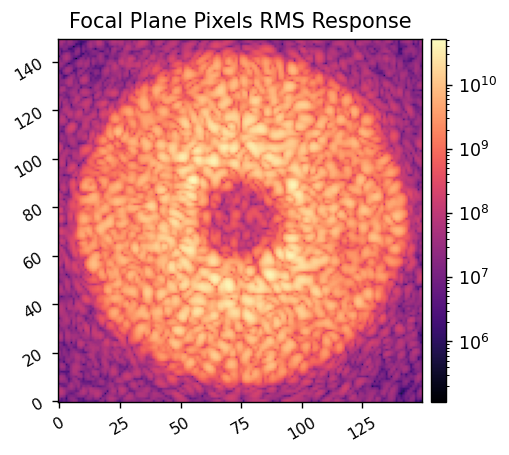

Saved data to:  /home/kianmilani/Projects/roman-cgi-iefc-data/response-data/test_response_matrix_20231009.fits
Saved data to:  /home/kianmilani/Projects/roman-cgi-iefc-data/response-data/test_response_cube_20231009.fits


In [36]:
reload(iefc_2dm)

calib_amp = 5e-9

response_matrix, response_cube = iefc_2dm.calibrate(mode, 
                                                    control_mask,
                                                    probe_amp, probe_modes, 
                                                     calib_amp, calib_modes[:2], 
                                                     return_all=True, 
#                                                     plot_responses=False,
                                                   )

utils.save_fits(response_dir/f'test_response_matrix_{today}.fits', response_matrix)
utils.save_fits(response_dir/f'test_response_cube_{today}.fits', response_cube)


In [7]:
# date = 20230630
# date = 20230703
# date = 20230713
# date = 20230720
# date = 20230723
# date = 20230804
# date = 20230806
# date = 20230808
# response_matrix = xp.array(fits.getdata(response_dir/f'bbspc_iefc_2dm_poke_response_matrix_{date}.fits'))
# response_cube = xp.array(fits.getdata(data_dir/response_dir/f'bbspc_iefc_2dm_poke_response_cube_{date}.fits'))

# date = 20230809
# response_matrix = xp.array(fits.getdata(response_dir/f'bbspc_iefc_2dm_had_response_matrix_{date}.fits'))
# response_cube = xp.array(fits.getdata(data_dir/response_dir/f'bbspc_iefc_2dm_had_response_cube_{date}.fits'))

# date = 20230912
# date = 20230913
# date = 20230918
# date = 20230925
date = 20231009
# date = 20231010
date = 20231013
date = 20240122
date = 20240129
response_matrix = xp.array(fits.getdata(response_dir/f'spc_wide_825_had_modes_response_matrix_{date}.fits'))
# response_cube = xp.array(fits.getdata(data_dir/response_dir/f'spc_wide_825_had_modes_response_cube_{date}.fits'))

9749694538968.9


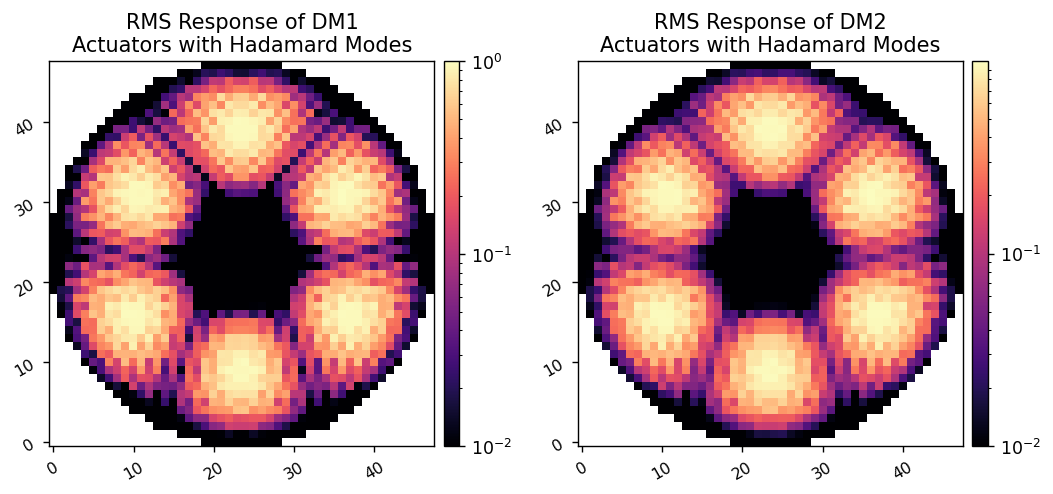

In [10]:
response_matrix.shape

dm_response = xp.sqrt(xp.mean(response_matrix.dot(xp.array(calib_modes))**2, axis=0))
dm1_response = dm_response[:mode.Nact**2].reshape(mode.Nact, mode.Nact)/dm_response.max()
dm2_response = dm_response[mode.Nact**2:].reshape(mode.Nact, mode.Nact)/dm_response.max()

print(dm_response.max())
imshow2(dm1_response, dm2_response, 
        'RMS Response of DM1\nActuators with Hadamard Modes', 'RMS Response of DM2\nActuators with Hadamard Modes',
        lognorm=True, vmin1=0.01, vmin2=0.01,
        )

In [107]:
5632018080336.246/2794403703.275511

2015.4632896222454

In [19]:
utils.fourier_filter_command()

<function utils.fourier_filter_command(command, iwa, owa)>

# Run IEFC

In [11]:
mode.reset_dms()
mode.exp_times_list = None

# imshow2(mode.get_dm1(), mode.get_dm2(), cmap1='viridis', cmap2='viridis')
images = xp.array([ref_im])
dm1_commands = xp.array([mode.get_dm1()])
dm2_commands = xp.array([mode.get_dm2()])
regs = xp.array([])


Running iEFC...
	Closed-loop iteration 28 / 30
False
False


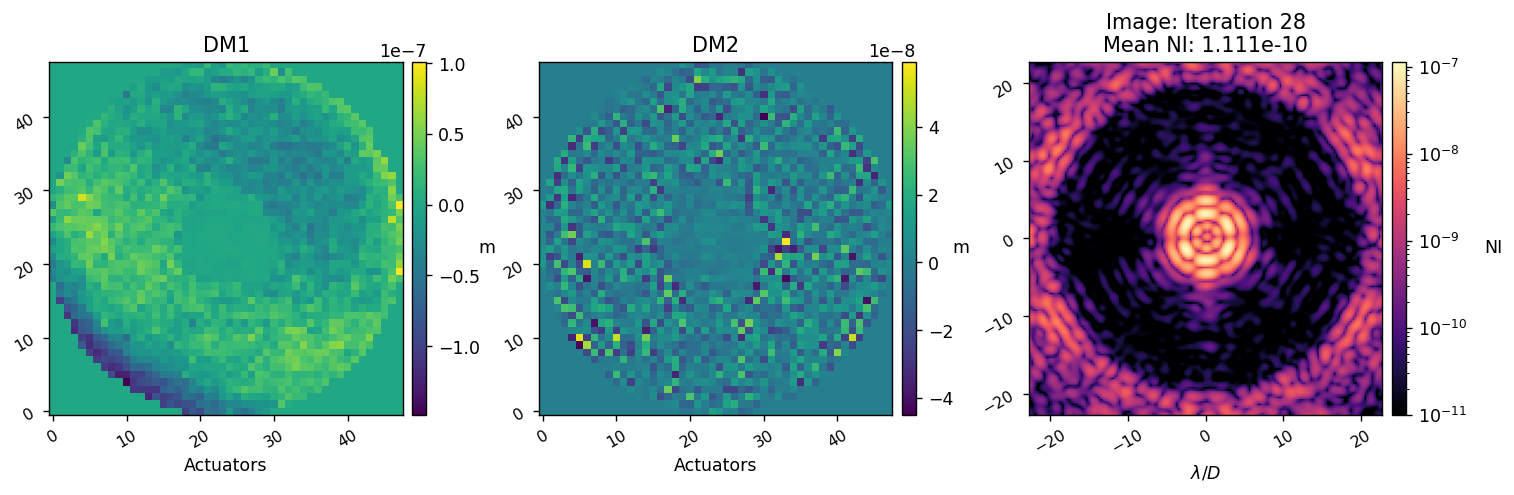

	Closed-loop iteration 29 / 30
False
False


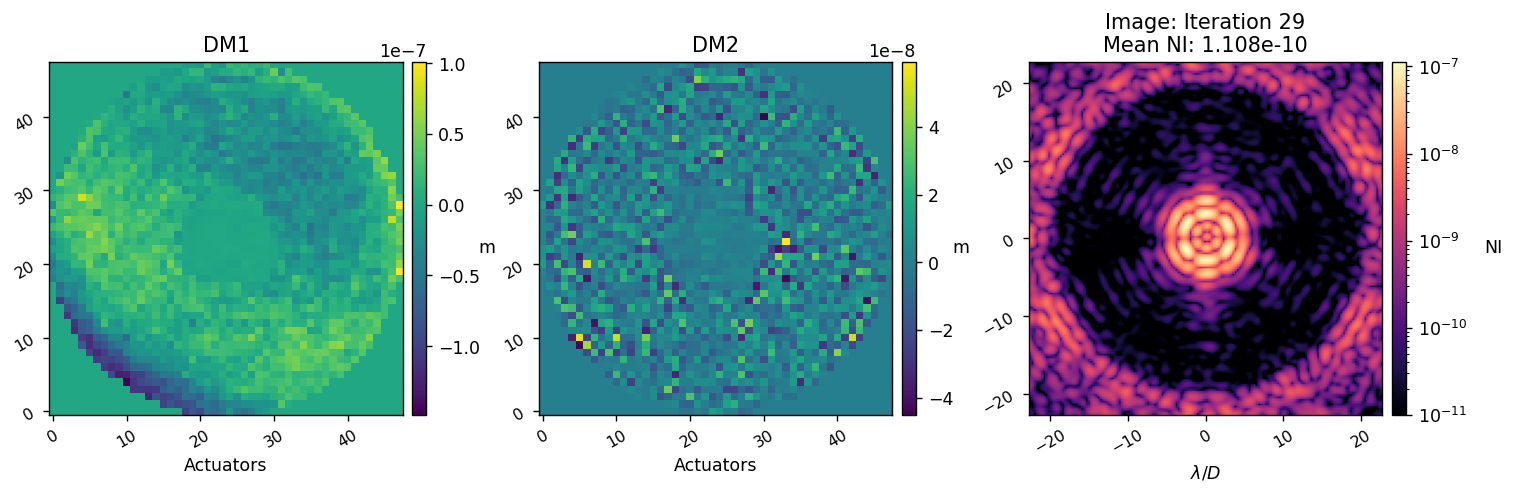

	Closed-loop iteration 30 / 30
False
False


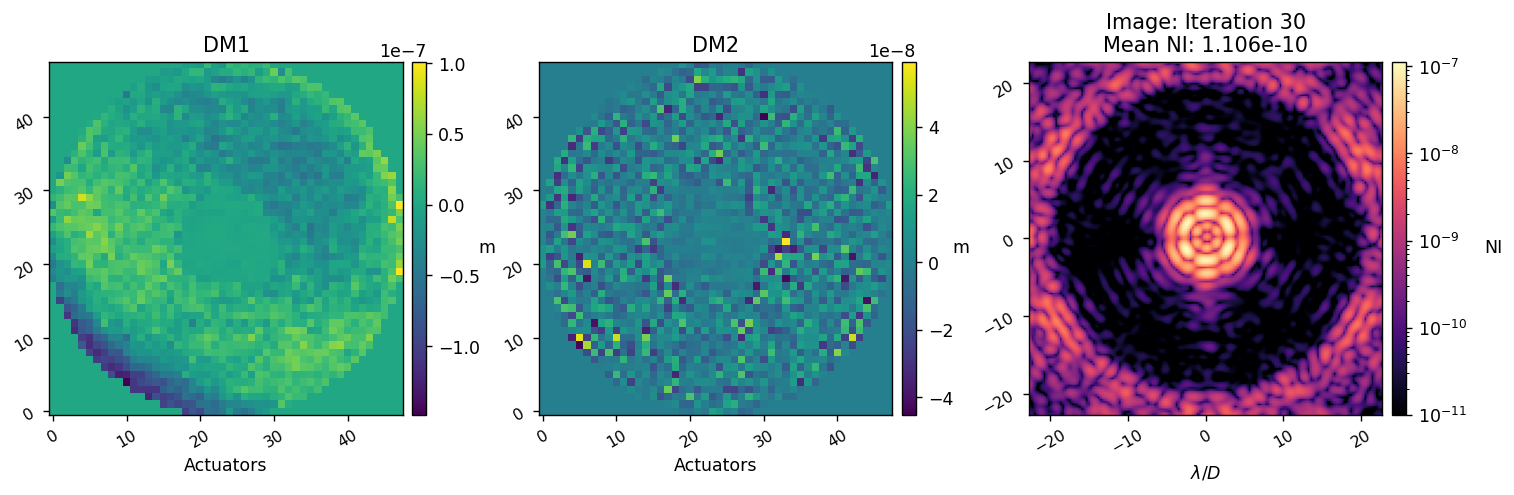

Closed loop for given control matrix completed in 8.639s.


In [21]:
reload(iefc_2dm)
reload(utils)

reg_fun = utils.beta_reg
reg_conds = -2.5
reg_conds = -4
# reg_conds = -5
# reg_conds = -6

probe_amp = 2.5e-9

images, dm1_commands, dm2_commands, regs = iefc_2dm.run(mode, 
                                                  # control_matrix, 
                                          response_matrix,
                                          reg_fun, reg_conds, 
                                          probe_modes, 
                                          probe_amp, 
                                          calib_modes,
                                          control_mask, 
                                          num_iterations=3, 
                                          loop_gain=0.5, 
                                          leakage=0,
#                                                   use_fourier_filter=True,
                                          plot_all=True,
                                         plot_radial_contrast=False,
                                                  old_images=images,
                                                  old_dm1_commands=dm1_commands,
                                                  old_dm2_commands=dm2_commands,
                                                  old_regs=regs,
                                         )

In [23]:
regs

array([-2.5, -2.5, -2.5, -6. , -6. , -6. , -2.5, -2.5, -2.5, -5. , -5. ,
       -5. , -2.5, -2.5, -2.5, -6. , -6. , -6. , -2.5, -2.5, -2.5, -5. ,
       -5. , -5. , -2.5, -2.5, -2.5, -4. , -4. , -4. ])

In [22]:
utils.save_fits(response_dir/f'spc_wfov_825_had_dm1_commands_{today}.fits', dm1_commands)
utils.save_fits(response_dir/f'spc_wfov_825_had_dm2_commands_{today}.fits', dm2_commands)
utils.save_fits(response_dir/f'spc_wfov_825_had_images_{today}.fits', images)
utils.save_fits(response_dir/f'spc_wfov_825_had_regs_{today}.fits', regs)

Saved data to:  /home/kianmilani/Projects/roman-cgi-iefc-data/response-data/spc_wfov_825_had_dm1_commands_20240131.fits
Saved data to:  /home/kianmilani/Projects/roman-cgi-iefc-data/response-data/spc_wfov_825_had_dm2_commands_20240131.fits
Saved data to:  /home/kianmilani/Projects/roman-cgi-iefc-data/response-data/spc_wfov_825_had_images_20240131.fits
Saved data to:  /home/kianmilani/Projects/roman-cgi-iefc-data/response-data/spc_wfov_825_had_regs_20240131.fits
